# COGS 108 Final Project

## Group Members: 
- A13382470
- A13870245
- A14765767
- A13871090
- A12752986

### Introduction and Background:



Which components of a kickstarter are most important for a fundraiser to reach its goal? How do factors such as date started, duration, money goal, and category of a kickstarter, comparatively, influence fundraiser success? Answering these questions can guide those who are looking to create their own kickstarter and start a successful business. There have been previous projects in this area studying what separates successful kickstarters from failed ones. We take a different approach and analyze how these factors rank against each other.  

Our initial hypothesis is that kickstarter category will be the most important factor in kickstarter success, due to some categories being inherently more popular and appealing than others. Categories such as technology will likely be more successful due to the popularity surrounding technology-driven products.


### Data Description:


Dataset Name: Kickstarter Datasets (Web Robots)

Link to the dataset: https://webrobots.io/kickstarter-datasets/ (We used the 2019-02-14 data)

Number of observations: 207k

The dataset is a large (200k+) collection of data about different Kickstarters, including whether they succeed in reaching their goal. Other information pertaining to the kickstarter range from the name and category of the kickstarter to how much it is asking for or how long the fundraising period was.

The information includes: ID, internal kickstarter id, name, name of project, category, main_category, category of campaign, currency used to support, deadline for crowdfunding, fundraising goal, date launched, amount pledged by "crowd", current condition the project is in.


### Starting out: imports

In [110]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import spearmanr
from scipy.stats import pearsonr



import json
import operator

from datetime import datetime, timedelta

### Data Cleaning and Pre-processing

Here we load the JSON file and select the columns that we want from the web-scraper's data. We also have to apply a function to parse the category name as it is separated by a forward slash 

In [2]:
with open('Kickstarter_2018-12-13T03_20_05_701Z.json') as f:
    
    data = []
    
    # Iterate through each line in file which is a JSON object
    for line in f:
        
        # Load object
        obj = json.loads(line)
 
        # Choose columns
        item = []
        item.append(obj['data']['id'])
        item.append(obj['data']['name'])
        item.append(obj['data']['blurb'])
        item.append(obj['data']['goal'])
        item.append(obj['data']['pledged'])
        item.append(obj['data']['state'])
        item.append(obj['data']['country'])
        item.append(obj['data']['deadline'])
        item.append(obj['data']['created_at'])
        item.append(obj['data']['launched_at'])
        item.append(obj['data']['backers_count'])
        item.append(obj['data']['usd_pledged'])
        item.append(obj['data']['category']['slug'])
        item.append(obj['data']['category']['name'])
        data.append(item)
        
# Fix columns list if adding/removing columns
columns = ['id', 'name', 'blurb', 'goal', 'pledged', 'state', 'country', 'deadline', 'created_at', 'launched_at', 'backers_count', 'usd_pledged', 'category', 'subcategory']
df = pd.DataFrame(data, columns=columns)

def getCategory(name):
    return name.split('/')[0]

# Fix category
df['category'] = df['category'].apply(getCategory)
df.head()

,id,name,blurb,goal,pledged,state,country,deadline,created_at,launched_at,backers_count,usd_pledged,category,subcategory
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,1353256229,1339525842,1350660629,170,27455.55,film & video,Documentary
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,1355949544,1351941026,1353357544,10,535.0,publishing,Children's Books
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,1418916011,1415917256,1416324011,0,0.0,journalism,Audio
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,1449345000,1446664703,1446672167,0,0.0,music,World Music
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,1287200340,1284003536,1284042614,62,6705.0,film & video,Documentary


Next, we notice that the deadline, created_at, and launched_at values look odd. Turns out they are in unix time, we we will transform them to be more readable.

In [3]:
deadline_str = []
duration_str = []
launch_date = []
deadline_int = []

for i, row in df.iterrows():

    unix_ts = int(row['deadline'])
    dt = (datetime.fromtimestamp(unix_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    deadline_str.append(dt)
    
    launch_date_ts = int(row['launched_at'])
    launch_dt = (datetime.fromtimestamp(launch_date_ts) - timedelta(hours=2)).strftime('%Y-%m-%d %H:%M:%S')
    launch_date.append(launch_dt)
    
    duration_unix_ts = unix_ts - launch_date_ts
    duration_days = (duration_unix_ts / (60*60*24))
    duration_str.append(duration_days)
    
df['launched_at_str'] = launch_date
df['deadline_str'] = deadline_str
df['duration_days'] = duration_str

for i, row in df.iterrows():
    
    dt = row['deadline_str']
    dt2 = dt.split(' ')[0].split('-')[1]+dt.split(' ')[0].split('-')[2]+dt.split(' ')[0].split('-')[0]
    deadline_int.append(dt2)

df['deadline_int'] = deadline_int

# Drop columns we don't need anymore
df.drop(labels=['deadline', 'created_at', 'launched_at'], axis=1, inplace=True)
    
# Check df
df.head()

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,170,27455.55,film & video,Documentary,2012-10-19 06:30:29,2012-11-18 06:30:29,30.041667,11182012
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,10,535.0,publishing,Children's Books,2012-11-19 10:39:04,2012-12-19 10:39:04,30.000000,12192012
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,0,0.0,journalism,Audio,2014-11-18 05:20:11,2014-12-18 05:20:11,30.000000,12182014
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,0,0.0,music,World Music,2015-11-04 11:22:47,2015-12-05 09:50:00,30.935567,12052015
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,62,6705.0,film & video,Documentary,2010-09-09 05:30:14,2010-10-15 18:39:00,36.547755,10152010


Check for any null values in our DataFrame

In [4]:
df.loc[df.isnull().any(axis=1)==True,:]

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int


As we can see above there are no rows with null values, so we don't have to worry about dealing with null values.

Now we will check for any outliers in the data within our goal column.

In [5]:
# Getting the mean and standard deviation of the goal column
mean = df['goal'].mean()
standardDev = df['goal'].std()
outOfRange = mean + (3*standardDev)

# remove any outliers that are found
outliers = []
for x in range(207227):
    if df.at[x,'goal'] > outOfRange:
        outliers.append(df.at[x,'goal'])
        
len(outliers)

238

As we can see, there were some outliers in the data so we removed them so we don't get abnormal results.

In [6]:
df = df[~df['goal'].isin(outliers)]
df

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,170,27455.55,film & video,Documentary,2012-10-19 06:30:29,2012-11-18 06:30:29,30.041667,11182012
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,10,535.0,publishing,Children's Books,2012-11-19 10:39:04,2012-12-19 10:39:04,30.000000,12192012
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,0,0.0,journalism,Audio,2014-11-18 05:20:11,2014-12-18 05:20:11,30.000000,12182014
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,0,0.0,music,World Music,2015-11-04 11:22:47,2015-12-05 09:50:00,30.935567,12052015
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,62,6705.0,film & video,Documentary,2010-09-09 05:30:14,2010-10-15 18:39:00,36.547755,10152010
5,1102245275,El Imaginario de Paula Sartre,Una comedia sobre la existencia y la realidad.,20000.0,0.00,failed,MX,0,0.0,theater,Comedy,2018-02-06 21:07:48,2018-02-21 21:07:48,15.000000,02212018
6,1419014581,Urban Rappel Getaway.,This is an ambitious film project for our Yout...,350.0,1.00,failed,US,1,1.0,film & video,Action,2017-04-06 13:03:34,2017-05-06 13:03:34,30.000000,05062017
7,636175622,IndyGo,Creating an outlet for independent musicians t...,10000.0,100.00,failed,US,1,100.0,music,World Music,2017-09-12 16:51:46,2017-10-12 16:51:46,30.000000,10122017
8,1439654389,White Rabbit Theatre's Thoroughly Modern Millie,White Rabbit Theatre brings highly entertainin...,700.0,700.00,successful,US,5,700.0,theater,Musical,2017-09-26 04:05:46,2017-11-10 04:05:46,45.041667,11102017
9,1901995478,Little Black Dress Opening,Little Black Dress is a growing company. This ...,50000.0,170.00,failed,CA,2,134.0628449,fashion,Couture,2015-04-01 08:40:29,2015-05-31 08:40:29,60.000000,05312015


### Data Visualization

#### Impact of Categories and Subcategories

Let's start by looking at how different categories and subcategories rank against each other:

In [7]:
# Code for successful kickstarters in 'category'
item = df['category'].unique()
out = {}
counts = df['category'].value_counts().tolist()
for val in item:
    temp = df[(df['category']== val) & (df['state']=='successful')]['id'].size
    out[val] = temp
    
# Code for successful kickstarters in 'subcategory'
item2 = df['subcategory'].unique()
out2 = {}
counts2 = df['subcategory'].value_counts().tolist()
dfTest = pd.DataFrame(item2, columns=['subcategory'])
searchFor = ['Literary Spaces', 'Letterpress', 'Chiptune', 'Taxidermy']
dfTest = dfTest[~dfTest['subcategory'].isin(searchFor)]
item2 = dfTest['subcategory'].unique()
for val in item2:
    temp2 = df[(df['subcategory']== val) & (df['state']=='successful')]['id'].size
    out2[val] = temp2
    
# Code to get success rate for 'category'
dict1 = df['category'].value_counts().to_dict() # total vals
dict2 = out # successful (out)
dict3 = {} # success rate
for cat in item:
    total = dict1[cat]
    success = dict2[cat]
    dict3[cat] = success/total
testList = list(dict3.values())
testList2 = np.sort(testList)
testList3 = testList2[::-1]
sorted_x = sorted(dict3.items(), key=operator.itemgetter(1), reverse=True)

# Code to get success rate for 'subcategory'
dict4 = df['subcategory'].value_counts().to_dict() # total vals
dict5 = out2 # successful (out)
dict6 = {} # success rate
for cat in item2:
    total2 = dict4[cat]
    success2 = dict5[cat]
    dict6[cat] = success2/total2
testList4 = list(dict6.values())
testList5 = np.sort(testList4)
testList6 = testList5[::-1]
sorted_x2 = sorted(dict6.items(), key=operator.itemgetter(1), reverse=True)

Here are the success rates for the first 15 categories and subcategories

In [8]:
print("Categories:")
for pair in sorted_x[:15]:
    print(pair[0], "{0:.2%}".format(pair[1]))

print("\nSubcategories:")
for pair in sorted_x2[:15]:
    print(pair[0], "{0:.2%}".format(pair[1]))

Categories:
dance 81.59%
comics 78.40%
theater 70.64%
publishing 68.02%
music 65.43%
games 61.03%
design 60.52%
fashion 57.00%
film & video 56.81%
art 55.97%
photography 50.08%
crafts 48.10%
technology 37.81%
food 34.34%
journalism 30.67%

Subcategories:
Theater 99.74%
Dance 99.62%
Photography 99.30%
Comics 99.19%
Indie Rock 98.95%
Country & Folk 98.04%
Fashion 97.96%
Rock 97.93%
Food 97.53%
Shorts 97.38%
Fiction 96.90%
Crafts 96.72%
Nonfiction 96.07%
Children's Books 95.08%
Documentary 94.03%


Now that we have the success rate for categories, we can plot them to show the differences

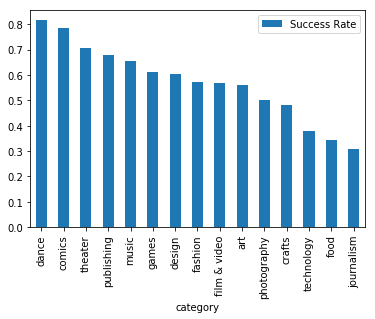

In [9]:
df_categories = pd.DataFrame.from_records(sorted_x, columns=['category', 'Success Rate'])
df_categories.plot(x='category', kind='bar')

Note that the top subcategories are artistic areas! We'll come back to this in our analysis.

#### Impact of Project Description Words

Next, we will visualize how using certain words to describe a Kickstarter project may have an effect on the success. We begin by separating successful and failed projects. Then, we want to create a dataframe with each word and the number of times it appears.

In [10]:
# Create dataframes for kickstarters that are successful and fail
df_successful = df.loc[df['state']=='successful',:]
df_fail = df.loc[df['state']=='failed',:]

In [11]:
# Create a dictionary of words with their counts
success_words = {}
fail_words = {}

for description in df_successful['blurb']:
    for word in description.split(' '):
        word = word.lower()
        word = word.strip()
        word = word.replace('.', '')
        word = word.replace("\"", '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.replace('!', '')
        word = word.replace('?', '')
        word = word.replace('\n', '')
        
        if len(word) == 0:
            continue
        elif word not in success_words:
            success_words[word] = 1
        else:
            success_words[word] += 1
            
for description in df_fail['blurb']:
    for word in description.split(' '):
        word = word.lower()
        word = word.strip()
        word = word.replace('.', '')
        word = word.replace("\"", '')
        word = word.replace(',', '')
        word = word.replace(';', '')
        word = word.replace('!', '')
        word = word.replace('?', '')
        word = word.replace('\n', '')
        
        if len(word) == 0:
            continue
        elif word not in fail_words:
            fail_words[word] = 1
        else:
            fail_words[word] += 1

df_success_words = pd.DataFrame.from_dict(success_words, orient='index', columns=['count'])
df_fail_words = pd.DataFrame.from_dict(fail_words, orient='index', columns=['count'])

We don't care about stop words, because they are bound to appear in any description. We want to focus on more unique words so these stop words (based on https://www.textfixer.com/tutorials/common-english-words.txt) will be dropped.

In [12]:
# Drop stop words
common = ['a','able','about','across','after','all','almost','also','am','among','an','and','any','are',
          'as','at','be','because','been','but','by','can','cannot','could','dear','did','do','does',
          'either','else','ever','every','for','from','get','got','had','has','have','he','her','hers',
          'him','his','how','however','i','if','in','into','is','it','its','just','least','let','like',
          'likely','may','me','might','most','must','my','neither','no','nor','not','of','off','often',
          'on','only','or','other','our','own','rather','said','say','says','she','should','since','so',
          'some','than','that','the','their','them','then','there','these','they','this','to','too',
          'twas','us','wants','was','we','were','what','when','where','which','while','who','whom','why',
          'will','with','would','yet','you','your', '-', '&', "i'm", "it's"]

df_success_words.drop(common, inplace=True)
df_fail_words.drop(common, inplace=True)

We have removed the stop words but there are also words that appear very few times. There no point in looking at words with such low counts so we will filter words that fall below a certain threshold. Here, we are aiming to narrow down to about 25 words, so that we are not overwhelmed with words.

In [13]:
# Get rid of words with low frequency
df_success_words = df_success_words.loc[df_success_words['count']>3000,:]
df_success_words.sort_values(by=['count'], ascending=False, inplace=True)

df_fail_words = df_fail_words.loc[df_fail_words['count']>2000,:]
df_fail_words.sort_values(by=['count'], ascending=False, inplace=True)

# Fix indexing and make column for word
df_success_words.reset_index(inplace=True)
df_success_words.columns = ['word', 'count']

df_fail_words.reset_index(inplace=True)
df_fail_words.columns = ['word', 'count']

In [14]:
df_success_words.head(n=10)

,word,count
0,help,14214
1,new,12968
2,book,7550
3,first,6902
4,album,6635
5,art,6405
6,music,5826
7,world,5647
8,make,5205
9,film,5117


In [15]:
df_fail_words.head(n=10)

,word,count
0,help,7192
1,new,5889
2,music,4133
3,make,4054
4,want,3874
5,world,3865
6,art,3690
7,create,3332
8,people,3201
9,project,3173


Now that we have the words and their counts, we can plot to see how common certain words in successful projects are

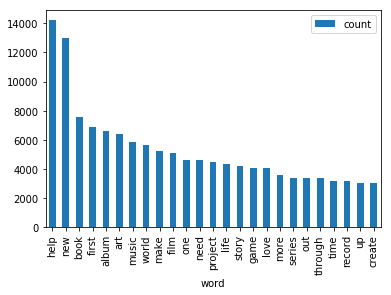

In [16]:
df_success_words.plot(x='word', kind='bar')

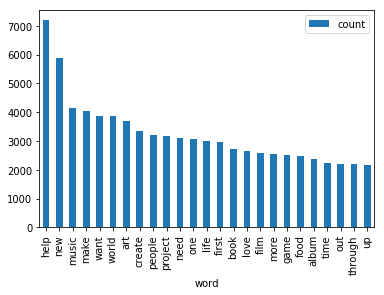

In [17]:
df_fail_words.plot(x='word', kind='bar')

We see some interesting words here. We will look more into them later in out analysis.

#### Impact of Start Date and Duration

We shall begin visualizing Start Date and Duration by making the dates more readable.

In [18]:
# Add column to df for Start Month
df['month'] = df.launched_at_str.str[5:7]

# Converts month from number form to name form
def convert_month(month):
    if month == "01":
        return "Jan"
    elif month == "02":
        return "Feb"
    elif month == "03":
        return "Mar"
    elif month == "04":
        return "Apr"
    elif month == "05":
        return "May"
    elif month == "06":
        return "Jun"
    elif month == "07":
        return "Jul"
    elif month == "08":
        return "Aug"
    elif month == "09":
        return "Sep"
    elif month == "10":
        return "Oct"
    elif month == "11":
        return "Nov"
    elif month == "12":
        return "Dec"

# Convert the month column of dataframe to name form
df['month'] = df['month'].apply(convert_month)

One aspect we can start examining is how many successful and unsuccessful projects are in each month to get a sense of what months are best and worst to start a kickstarter project.

In [19]:
# Dictionaries to keep track of counts for each month
month_success = {'Jan':0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}
month_fail = {'Jan':0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for index,row in df.iterrows():
    month = row['month']
    #Add to success dictionary
    if row['state'] == 'successful':
        if month in month_success:
            month_success[month] = month_success[month] + 1
        else:
            month_success[month] = 1
    #Add to failed dictionary
    elif row['state'] == 'failed':
        if month in month_fail:
            month_fail[month] = month_fail[month] + 1
        else:
            month_fail[month] = 1
      
print("Count for success months:")
for key in month_success:
    print(key, month_success[key])

print("\nCount for fail months:")
for key in month_fail:
    print(key, month_fail[key])

Count for success months:
Jan 8892
Feb 9880
Mar 10889
Apr 10453
May 10722
Jun 10281
Jul 10345
Aug 9651
Sep 9623
Oct 10246
Nov 9427
Dec 6110

Count for fail months:
Jan 5905
Feb 5899
Mar 6154
Apr 6024
May 6349
Jun 6456
Jul 8341
Aug 6987
Sep 6203
Oct 6308
Nov 5956
Dec 4430


We can already see some slight differences in project counts. Let's plot success and fail counts, so we can visualize the data better.

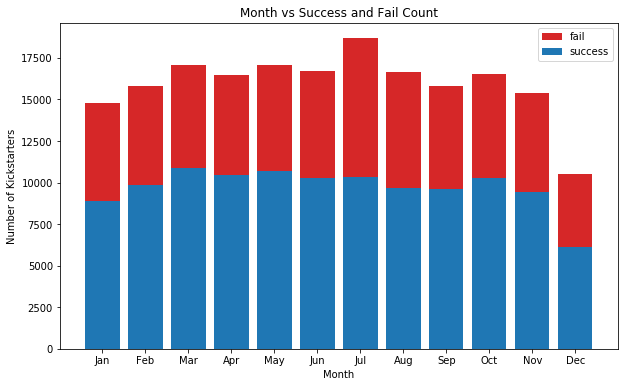

In [20]:
# Create lists to plot
month_list = list(month_success.keys())
month_success_count_list = list(month_success.values())
month_fail_count_list = list((month_fail.values()))

# Create plot
ind = [x for x, _ in enumerate(month_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, month_fail_count_list, width=0.8, label='fail', color='tab:red', bottom=month_success_count_list)
plt.bar(ind, month_success_count_list, width=0.8, label='success', color='tab:blue')

# Add labels, title, and legend
plt.ylabel("Number of Kickstarters")
plt.title("Month vs Success and Fail Count")
plt.xticks(ind, month_list)
plt.xlabel("Month")
plt.legend()

plt.show()

We see that certain months are more popular in terms of project count than others, but the success rate of each month is also important, so we shall explore that next.

In [21]:
# Function that takes success and fail counts to get a success rate
def get_success_rate(success_list, fail_list):
    success_rate = []
    for i, count in enumerate(success_list):
        success_rate.append(count/(count+fail_list[i]))
    return success_rate

# Get list of success_rates for each month
month_success_rate = get_success_rate(month_success_count_list, month_fail_count_list)

print("Success rate per month:")
for i, month in enumerate(month_success):
    print(month, "{0:.2%}".format(month_success_rate[i]))

Success rate per month:
Jan 60.09%
Feb 62.61%
Mar 63.89%
Apr 63.44%
May 62.81%
Jun 61.43%
Jul 55.36%
Aug 58.01%
Sep 60.81%
Oct 61.89%
Nov 61.28%
Dec 57.97%


Let's plot these success rates to better visualize trends with certain months.

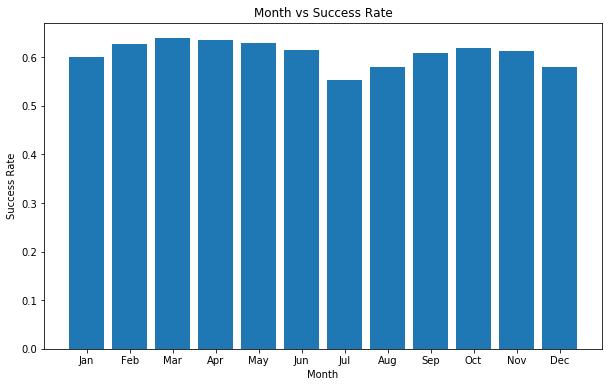

In [22]:
# Create plot
plt.figure(figsize=(10, 6))
plt.bar(ind, month_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Month vs Success Rate")
plt.xticks(ind, month_list)
plt.xlabel("Month")

plt.show()

We notice a very slight bimodal distribution. We will look into this more in our analysis.

Next up, we will see how the duration of time that a kickstart is up affect it's success.

In [23]:
# Create groups of 10 (0-100)
def convert_duration(duration):
    if duration > 90:
        return "91+"
    elif duration > 80:
        return "81-90"
    elif duration > 70:
        return "71-80"
    elif duration > 60:
        return "61-70"
    elif duration > 50:
        return "51-60"
    elif duration > 40:
        return "41-50"
    elif duration > 30:
        return "31-40"
    elif duration > 20:
        return "21-30"
    elif duration > 10:
        return "11-20"
    elif duration <= 10:
        return "0-10"

# Add column to df for the kickstarts duration group
df['duration_group'] = df['duration_days'].apply(convert_duration)

In [24]:
# Dictionaries to keep track of counts for each duration group
duration_success = {'0-10':0, '11-20': 0, '21-30': 0, '31-40': 0, '41-50': 0, '51-60': 0, '61-70': 0, '71-80': 0, '81-90': 0, '91+': 0}
duration_fail = {'0-10':0, '11-20': 0, '21-30': 0, '31-40': 0, '41-50': 0, '51-60': 0, '61-70': 0, '71-80': 0, '81-90': 0, '91+': 0}

for index,row in df.iterrows():
    duration = row['duration_group']
    #Add to success dictionary
    if row['state'] == 'successful':
        if duration in duration_success:
            duration_success[duration] = duration_success[duration] + 1
        else:
            duration_success[duration] = 1
    #Add to failed dictionary
    elif row['state'] == 'failed':
        if duration in duration_fail:
            duration_fail[duration] = duration_fail[duration] + 1
        else:
            month_fail[duration] = 1

print("Count for success durations:")
for key in duration_success:
    print(key, duration_success[key])

print("\nCount for fail durations:")
for key in duration_fail:
    print(key, duration_fail[key])

Count for success durations:
0-10 2448
11-20 9420
21-30 56819
31-40 26560
41-50 10358
51-60 7200
61-70 2004
71-80 397
81-90 1045
91+ 268

Count for fail durations:
0-10 1299
11-20 4388
21-30 39669
31-40 11909
41-50 6247
51-60 9416
61-70 1597
71-80 86
81-90 313
91+ 88


Let's plot these success and fail counts to better visualize trends with certain duration groups.

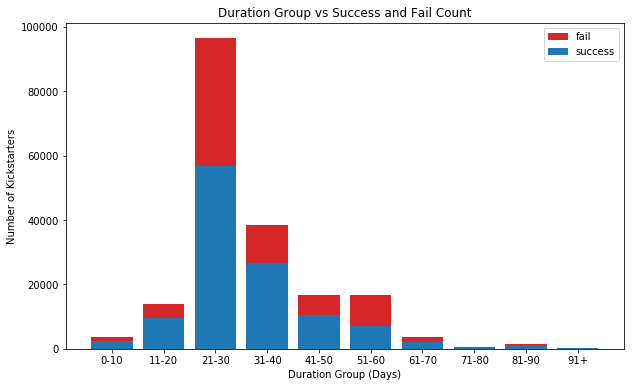

In [25]:
# Create lists to plot
duration_list = list(duration_success.keys())
duration_success_count_list = list(duration_success.values())
duration_fail_count_list = list((duration_fail.values()))

# Create plot
ind = [x for x, _ in enumerate(duration_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, duration_fail_count_list, width=0.8, label='fail', color='tab:red', bottom=duration_success_count_list)
plt.bar(ind, duration_success_count_list, width=0.8, label='success', color='tab:blue')

# Add labels, title, and legend
plt.ylabel("Number of Kickstarters")
plt.title("Duration Group vs Success and Fail Count")
plt.xticks(ind, duration_list)
plt.xlabel("Duration Group (Days)")
plt.legend()

plt.show()

Once again, we have the success and fail counts, but let's also examine the success rate for more detail.

In [26]:
# Get list of success_rates for each month
duration_success_rate = get_success_rate(duration_success_count_list, duration_fail_count_list)

print("Success rate per duration:")
for i, key in enumerate(duration_success):
    print(key, "{0:.2%}".format(duration_success_rate[i]))

Success rate per duration:
0-10 65.33%
11-20 68.22%
21-30 58.89%
31-40 69.04%
41-50 62.38%
51-60 43.33%
61-70 55.65%
71-80 82.19%
81-90 76.95%
91+ 75.28%


Let's plot these success rates to better visualize trends with certain project durations.

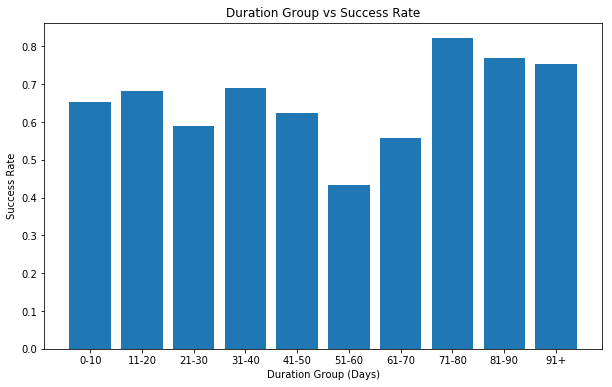

In [27]:
# Create plot
plt.figure(figsize=(10, 6))
plt.bar(ind, duration_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Duration Group vs Success Rate")
plt.xticks(ind, duration_list)
plt.xlabel("Duration Group (Days)")

plt.show()

Unfortunately, success rates seem quite random. We'll discuss this further in the analysis.

#### Impact of Goal Amount

Let's begin by splitting up the goal into ranges of $10,000

In [28]:
def convert_goal(goal_amt):
    if goal_amt >= 100000:
        return "100K+"
    elif goal_amt >= 90000:
        return "90-100K"
    elif goal_amt >= 80000:
        return "80-90K"
    elif goal_amt >= 70000:
        return "70-80K"
    elif goal_amt >= 60000:
        return "60-70K"
    elif goal_amt >= 50000:
        return "50-60K"
    elif goal_amt >= 40000:
        return "40-50K"
    elif goal_amt >= 30000:
        return "30-40K"
    elif goal_amt >= 20000:
        return "20-30K"
    elif goal_amt >= 10000:
        return "10-20K"
    elif goal_amt < 10000:
        return "0-10K"
    
df['goal_group'] = df['goal'].apply(convert_goal)

In [29]:
# Dictionaries to keep track of counts for each goal group
goal_success = {'0-10K':0, '10-20K': 0, '20-30K': 0, '30-40K': 0, '40-50K': 0, '50-60K': 0, '60-70K': 0, '70-80K': 0, '80-90K': 0, '90-100K': 0, '100K+': 0}
goal_fail = {'0-10K':0, '10-20K': 0, '20-30K': 0, '30-40K': 0, '40-50K': 0, '50-60K': 0, '60-70K': 0, '70-80K': 0, '80-90K': 0, '90-100K': 0, '100K+': 0}

for index,row in df.iterrows():
    goal_grp = row['goal_group']
    #Add to success dictionary
    if row['state'] == 'successful':
        if goal_grp in goal_success:
            goal_success[goal_grp] = goal_success[goal_grp] + 1
        else:
            goal_success[goal_grp] = 1
    #Add to failed dictionary
    elif row['state'] == 'failed':
        if goal_grp in goal_fail:
            goal_fail[goal_grp] = goal_fail[goal_grp] + 1
        else:
            goal_fail[goal_grp] = 1

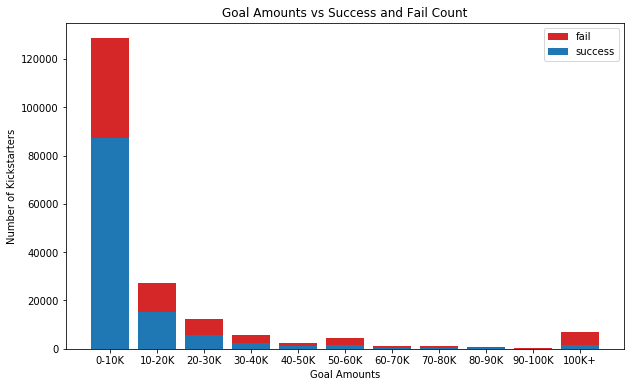

In [30]:
# Create lists to plot
goal_list = list(goal_success.keys())
goal_success_count_list = list(goal_success.values())
goal_fail_count_list = list((goal_fail.values()))

# Create plot
plt.figure(figsize=(10, 6))
ind = [x for x, _ in enumerate(goal_list)]
plt.bar(ind, goal_fail_count_list, width=0.8, label='fail', color='tab:red', bottom=goal_success_count_list)
plt.bar(ind, goal_success_count_list, width=0.8, label='success', color='tab:blue')

# Add labels, title, and legend
plt.ylabel("Number of Kickstarters")
plt.title("Goal Amounts vs Success and Fail Count")
plt.xticks(ind, goal_list)
plt.xlabel("Goal Amounts")
plt.legend()

plt.show()

Success rate for goal amounts:

In [50]:
# Get list of success_rates for each goal
goal_success_rate = get_success_rate(goal_success_count_list, goal_fail_count_list)

print("Success rate per goal:")
for i, key in enumerate(goal_success):
    print(key, "{0:.2%}".format(goal_success_rate[i]))

Success rate per goal:
0-10K 68.01%
10-20K 56.28%
20-30K 47.83%
30-40K 44.53%
40-50K 41.11%
50-60K 33.77%
60-70K 31.45%
70-80K 34.10%
80-90K 29.44%
90-100K 29.15%
100K+ 22.18%


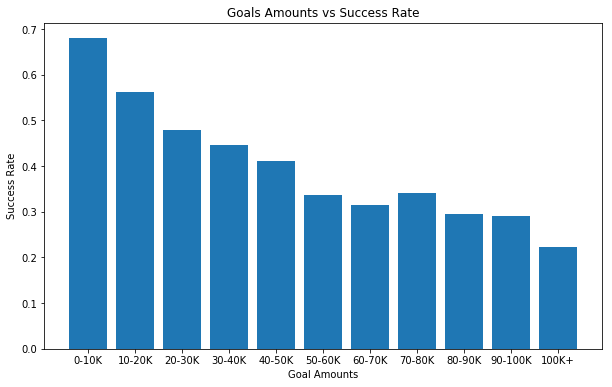

In [51]:
# Create plot
ind = [x for x, _ in enumerate(goal_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, goal_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Goals Amounts vs Success Rate")
plt.xticks(ind, goal_list)
plt.xlabel("Goal Amounts")

plt.show()

A large portion of kickstarter projects have low success goals in the 0-10k region. To get more detail, we will also break down goal amounts within the 0-10K range and check if there is anything significant.

In [31]:
def convert_goal_small(goal_amt):
    if goal_amt <=10000 and goal_amt >= 9000:
        return "9-10K"
    elif goal_amt >= 8000:
        return "8-9K"
    elif goal_amt >= 7000:
        return "7-8K"
    elif goal_amt >= 6000:
        return "6-7K"
    elif goal_amt >= 5000:
        return "5-6K"
    elif goal_amt >= 4000:
        return "4-5K"
    elif goal_amt >= 3000:
        return "3-4K"
    elif goal_amt >= 2000:
        return "2-3K"
    elif goal_amt >= 1000:
        return "1-2K"
    elif goal_amt < 1000:
        return "0-1K"
    else:
        return "Large"
    
df['goal_group_small'] = df['goal'].apply(convert_goal_small)
df.head()

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int,month,duration_group,goal_group,goal_group_small
0,1555581815,Big Top Without Borders,A documentary about two circuses in remote cor...,25000.0,27455.55,successful,US,170,27455.55,film & video,Documentary,2012-10-19 06:30:29,2012-11-18 06:30:29,30.041667,11182012,Oct,31-40,20-30K,8-9K
1,583419300,"The Story of ""Pweep"": From Egg - To Peacock",A multi-media IPad book telling the true story...,500.0,535.00,successful,US,10,535.0,publishing,Children's Books,2012-11-19 10:39:04,2012-12-19 10:39:04,30.000000,12192012,Nov,21-30,0-10K,0-1K
2,1745190062,DC Radio,We are college students that get drunk and the...,3500.0,0.00,failed,CA,0,0.0,journalism,Audio,2014-11-18 05:20:11,2014-12-18 05:20:11,30.000000,12182014,Nov,21-30,0-10K,3-4K
3,1995203117,Ali Bangerz- two New Full Lenght Albums,"its Ali bangerz,its time to stand up for other...",20000.0,0.00,failed,US,0,0.0,music,World Music,2015-11-04 11:22:47,2015-12-05 09:50:00,30.935567,12052015,Nov,31-40,20-30K,8-9K
4,359013399,Deja-Vu: Dissecting Memory on Camera,A young neuroscientist attempts to reconnect w...,5000.0,6705.00,successful,US,62,6705.0,film & video,Documentary,2010-09-09 05:30:14,2010-10-15 18:39:00,36.547755,10152010,Sep,31-40,0-10K,5-6K
5,1102245275,El Imaginario de Paula Sartre,Una comedia sobre la existencia y la realidad.,20000.0,0.00,failed,MX,0,0.0,theater,Comedy,2018-02-06 21:07:48,2018-02-21 21:07:48,15.000000,02212018,Feb,11-20,20-30K,8-9K
6,1419014581,Urban Rappel Getaway.,This is an ambitious film project for our Yout...,350.0,1.00,failed,US,1,1.0,film & video,Action,2017-04-06 13:03:34,2017-05-06 13:03:34,30.000000,05062017,Apr,21-30,0-10K,0-1K
7,636175622,IndyGo,Creating an outlet for independent musicians t...,10000.0,100.00,failed,US,1,100.0,music,World Music,2017-09-12 16:51:46,2017-10-12 16:51:46,30.000000,10122017,Sep,21-30,10-20K,9-10K
8,1439654389,White Rabbit Theatre's Thoroughly Modern Millie,White Rabbit Theatre brings highly entertainin...,700.0,700.00,successful,US,5,700.0,theater,Musical,2017-09-26 04:05:46,2017-11-10 04:05:46,45.041667,11102017,Sep,41-50,0-10K,0-1K
9,1901995478,Little Black Dress Opening,Little Black Dress is a growing company. This ...,50000.0,170.00,failed,CA,2,134.0628449,fashion,Couture,2015-04-01 08:40:29,2015-05-31 08:40:29,60.000000,05312015,Apr,51-60,50-60K,8-9K


In [32]:
# Dictionaries to keep track of counts for each goal subset group
goal_subset_success = {'9-10K':0, '8-9K': 0, '7-8K': 0, '6-7K': 0, '5-6K': 0, '4-5K': 0, '3-4K': 0, '2-3K': 0, '1-2K': 0, '0-1K': 0}
goal_subset_fail = {'9-10K':0, '8-9K': 0, '7-8K': 0, '6-7K': 0, '5-6K': 0, '4-5K': 0, '3-4K': 0, '2-3K': 0, '1-2K': 0, '0-1K': 0}

for index,row in df.iterrows():
    goal_subset_grp = row['goal_group_small']
    #Add to success dictionary
    if row['state'] == 'successful' and row['goal'] <= 10000:
        if goal_subset_grp in goal_subset_success:
            goal_subset_success[goal_subset_grp] = goal_subset_success[goal_subset_grp] + 1
        else:
            goal_subset_success[goal_grp] = 1
    #Add to failed dictionary
    elif row['state'] == 'failed' and row['goal'] <= 10000:
        if goal_subset_grp in goal_subset_fail:
            goal_subset_fail[goal_subset_grp] = goal_subset_fail[goal_subset_grp] + 1
        else:
            goal_subset_fail[goal_subset_grp] = 1
            
print("Count for success goals within 0-10K:")
for key in goal_subset_success:
    print(key, goal_subset_success[key])

print("\nCount for fail goals within 0-10K:")
for key in goal_subset_fail:
    print(key, goal_subset_fail[key])

Count for success goals within 0-10K:
9-10K 7674
8-9K 2887
7-8K 3635
6-7K 3737
5-6K 10056
4-5K 5228
3-4K 10241
2-3K 12828
1-2K 15591
0-1K 22013

Count for fail goals within 0-10K:
9-10K 6247
8-9K 1599
7-8K 2045
6-7K 1978
5-6K 7147
4-5K 2207
3-4K 4733
2-3K 5786
1-2K 6855
0-1K 7984


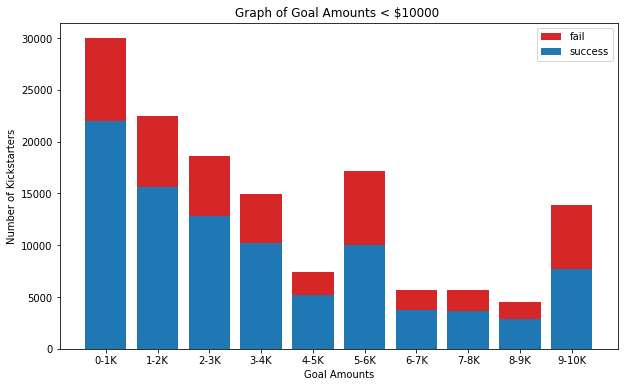

In [33]:
# Create lists to plot
goal_subset_list = list(goal_subset_success.keys())
goal_subset_success_count_list = list(goal_subset_success.values())
goal_subset_fail_count_list = list((goal_subset_fail.values()))

goal_subset_list.reverse()
goal_subset_success_count_list.reverse()
goal_subset_fail_count_list.reverse()

# Create plot
plt.figure(figsize=(10, 6))
ind = [x for x, _ in enumerate(goal_subset_list)]
plt.bar(ind, goal_subset_fail_count_list, width=0.8, label='fail', color='tab:red', bottom=goal_subset_success_count_list)
plt.bar(ind, goal_subset_success_count_list, width=0.8, label='success', color='tab:blue')

# Add labels, title, and legend
plt.ylabel("Number of Kickstarters")
plt.title("Graph of Goal Amounts < $10000 ")
plt.xticks(ind, goal_subset_list)
plt.xlabel("Goal Amounts")
plt.legend()

plt.show()

Now for the success rate:

In [34]:
# Get list of success_rates for each goal within 0-10K
goal_subset_success_rate = get_success_rate(goal_subset_success_count_list, goal_subset_fail_count_list)

print("Success rate per goal within 0-10K:")
for i, key in enumerate(goal_subset_success):
    print(key, "{0:.2%}".format(goal_subset_success_rate[i]))

Success rate per goal within 0-10K:
9-10K 73.38%
8-9K 69.46%
7-8K 68.92%
6-7K 68.39%
5-6K 70.32%
4-5K 58.45%
3-4K 65.39%
2-3K 64.00%
1-2K 64.36%
0-1K 55.13%


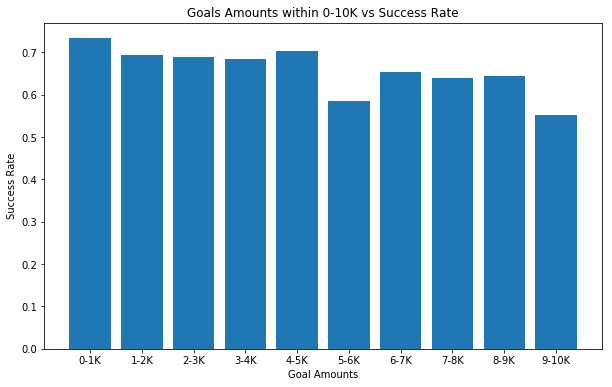

In [35]:
# Create plot
plt.figure(figsize=(10, 6))
plt.bar(ind, goal_subset_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Goals Amounts within 0-10K vs Success Rate")
plt.xticks(ind, goal_subset_list)
plt.xlabel("Goal Amounts")

plt.show()

There isn't a very strong pattern, but there is some relation of lower goals being slightly more successful. We will discuss this further in our analysis.

### Data Analysis and Results##

#### Impact of Categories and Subcategories

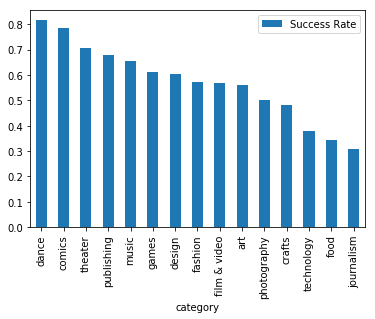

In [108]:
df_categories = pd.DataFrame.from_records(sorted_x, columns=['category', 'Success Rate'])
df_categories.plot(x='category', kind='bar')

In [54]:
print("Category Success Rates:")
for pair in sorted_x[:15]:
    print(pair[0], "{0:.2%}".format(pair[1]))

Category Success Rates:
dance 81.59%
comics 78.40%
theater 70.64%
publishing 68.02%
music 65.43%
games 61.03%
design 60.52%
fashion 57.00%
film & video 56.81%
art 55.97%
photography 50.08%
crafts 48.10%
technology 37.81%
food 34.34%
journalism 30.67%


There is a very clear linear relationship between category and success rate. Certain categorys are simply more successful than others. This supports with our hypothesis that the category of a kickstarter will have a great impact on success. From examining the most successful categories we see that the top 5 categories (from most successful to least) are dance, comics, theater, publishing, and music. Dance was by far the most successful category with a success rate of ~81%. It is important to note that the top 5 categories are all artistic. This goes against our initial hypothesis of technology being the most popular.

In [113]:
category_success_rate = []
for pair in sorted_x:
    category_success_rate.append(pair[1])
    
ind = [x for x in range(1,16)]
pearsonr_coefficient, p_value = pearsonr(category_success_rate, ind)
print("Pearson's Rank Correlation Coefficient: "+ "{:.3f}".format(pearsonr_coefficient))
print("p-val: ", p_value)

Pearson's Rank Correlation Coefficient: -0.981
p-val:  1.2836849039945476e-10


When calculating Spearman's rank correlation coefficient

While category is important, it is also important to keep in mind the subcategory that the project is under. For example, we can look at comics which is the 2nd most successful category with a 78.4% success rate.

In [37]:
df_comics = df.loc[df['category']=='comics']
df_comics['subcategory'].value_counts()

Comic Books       2585
Graphic Novels    2516
Comics            1964
Webcomics          875
Anthologies        579
Events             204
Name: subcategory, dtype: int64

Those are the subcategories under comics. We should see the spread of success rates between these subcategories.

In [38]:
for i, subcategory in enumerate(sorted_x2):
    if subcategory[0] == 'Comic Books' or subcategory[0] == 'Graphic Novels' or subcategory[0] == 'Comics' or subcategory[0] == 'Webcomics' or subcategory[0] == 'Anthologies' or subcategory[0] == 'Events':
        print(subcategory[0], "{0:.2%}".format(subcategory[1]))

Comics 99.19%
Comic Books 92.26%
Anthologies 69.55%
Webcomics 58.51%
Graphic Novels 58.39%
Events 21.01%


It turns outs Comics have a 99.19% success rate, but Events (comic events) have a 21.01% success rate. That is a pretty wide spread. However, only about 2% of kickstarter projects under comics are Events, while comics, comic books, and graphic novels are about 81% of kickstart projects under comics and they are 99% 92%, and 69% successful respectively, which are very high percentages. Therefore, although there can be some spread of success within categories, the categories themselves are a good indicator of a projects success.

#### Impact of Project Description Words

In the data visualization, we saw that the top 5 words to used in successful projects were "help", "new", "book", "first", and "album". However, it seemed a bit suspicious that using the word "help" had such an impact on the success of a kickstarter. Therefore, we examined the unsuccessful projects and "help" was also the most used word. The same applied to the word "new". This brings us towards the idea that "help" and "new" are words common to any Kickstarter project, especially with their extremely high counts, and their use does not have a direct relation with the success of a project. If we look at the bar plots we had generated before, the word count increase quite linearly, but once we get to "help" and "new", the values jump up eratically. We shall drop these two words from our dataframes.

In [39]:
df_success_words = df_success_words.loc[ ( (df_success_words['word'] != 'help') & (df_success_words['word'] != 'new') ),: ]
df_success_words.reset_index(drop=True, inplace=True)

df_fail_words = df_fail_words.loc[ ( (df_fail_words['word'] != 'help') & (df_fail_words['word'] != 'new') ),: ]
df_fail_words.reset_index(drop=True, inplace=True)

print("Success words: ")
print(list(df_success_words['word']))
print("\nFail words: ")
print(list(df_fail_words['word']))

Success words: 
['book', 'first', 'album', 'art', 'music', 'world', 'make', 'film', 'one', 'need', 'project', 'life', 'story', 'game', 'love', 'more', 'series', 'out', 'through', 'time', 'record', 'up', 'create']

Fail words: 
['music', 'make', 'want', 'world', 'art', 'create', 'people', 'project', 'need', 'one', 'life', 'first', 'book', 'love', 'film', 'more', 'game', 'food', 'album', 'time', 'out', 'through', 'up']


Even without "help" and "new", we still find a bunch of words in the succesful projects that are also top words in unsuccessful projects. This leads us to believe that perhaps these words don't have an effect on the success on a Kickstarter. It makes sense that these words are common in both successful and failed projects because they relate to the different categories and subcategories. For example, many kickstarter projects will be about books, music, art, dance, etc. A Kickstarter project in a particular category is probably going to mention words pertaining to its category and doing so probably will not affect the success or failure since it is bound to happen in virtually all project descriptions. Just to make sure, we will look for top words that only appear in successful and see if they would be significant or not towards a project's success.

In [40]:
def find_uniques(list1, list2):
    result = []
    for word in list1:
        if word not in list2:
            result.append(word) 
    return result

uniques = find_uniques(list(df_success_words['word']), list(df_fail_words['word']))
print(uniques)

['story', 'series', 'record']


We find that the only uniquely successful words are 'story', 'series', and 'record'. Based on the dataset, these words have some correlation to success but it is not the causation of success. One connection is that these three words are all related to some form of art such as books, comics, and music, and the arts tend to be the more popular categories. Therefore, one cannot use certain words to directly make their Kickstarter project succeed. Instead, it seems that the category of the project drives users to use certain words to describe their project and certain categories are more successful than others.

#### Impact of Start Date and Duration

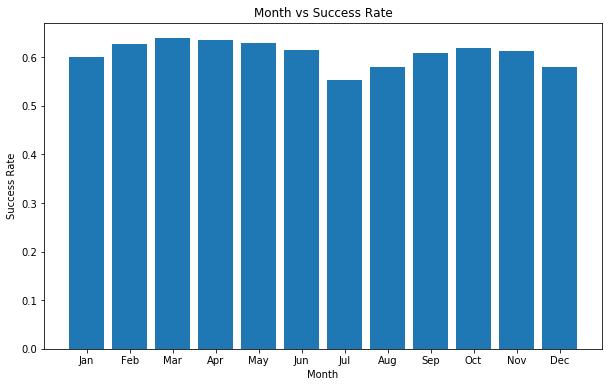

In [41]:
# Create plot
ind = [x for x, _ in enumerate(month_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, month_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Month vs Success Rate")
plt.xticks(ind, month_list)
plt.xlabel("Month")

plt.show()

In [58]:
print("Success rate per month:")
for i, month in enumerate(month_success):
    print(month, "{0:.2%}".format(month_success_rate[i]))

Success rate per month:
Jan 60.09%
Feb 62.61%
Mar 63.89%
Apr 63.44%
May 62.81%
Jun 61.43%
Jul 55.36%
Aug 58.01%
Sep 60.81%
Oct 61.89%
Nov 61.28%
Dec 57.97%


The above data shows the kickstarter success rate based on starting month. Looking at these values, we see that the best month to start a kickstarter is March, with April being a close runner up. According to our data, the worst month to start a kickstarter is July, which is also the month with the most kickstarter projects. One reason why the success rate might be so low in July is because of the influx of kickster projects that makes it more difficult for individuals to succeed. The pattern of success rate seems to dip in Dec/Jan and July, and peak in Mar/Apr and Oct/Nov. The dataset includes projects over multiple years, so the pattern must be relatively consistent for it to show up like so on our bar graph. The reason for these peaks are not immediately clear. Before seeing the data, one may assume that people usually spend more towards the end of the year, which is the holidays, but that does not seem to be the case. The underlying reasons are unclear, but nonetheless, it appears that the best time to launch a kickstart are Mar/Apr and Oct/Nov.

Next we will analyze the duration of kickstarter projects:

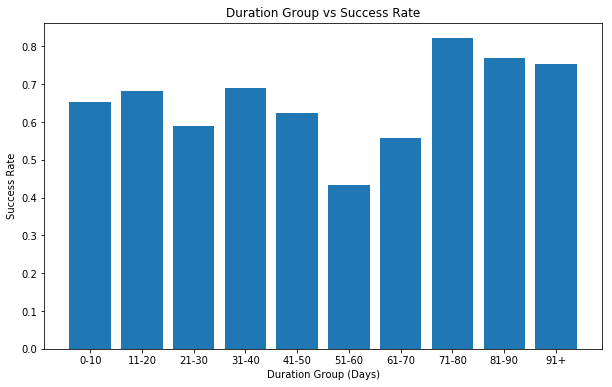

In [43]:
# Create plot
ind = [x for x, _ in enumerate(duration_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, duration_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Duration Group vs Success Rate")
plt.xticks(ind, duration_list)
plt.xlabel("Duration Group (Days)")

plt.show()

In [44]:
print("Success rate per duration:")
for i, key in enumerate(duration_success):
    print(key, "{0:.2%}".format(duration_success_rate[i]))
    
print("\nMedian Days: " + str(df['duration_days'].median()))
print("Mean Days: " + str(df['duration_days'].mean()))
print("STD Days: " + str(df['duration_days'].std()))

Success rate per duration:
0-10 65.33%
11-20 68.22%
21-30 58.89%
31-40 69.04%
41-50 62.38%
51-60 43.33%
61-70 55.65%
71-80 82.19%
81-90 76.95%
91+ 75.28%

Median Days: 30.0
Mean Days: 33.90801886133008
STD Days: 12.905783597465314


We observed that the Median amount of days was 30 and the Mean amount of days was ~34. The data also had a standard deviation of around 12.9 days. This makes sense because the overall success rate of a kickstarter (56.3%) is generally close to the success rates shown in the 21-30 and 31-40 intervals. 

Additionally, the above data shows the kickstarter success rate based on duration in intervals of 10 day periods. There doesn't seem to be any pattern as the distribution looks quite random. This data indicates that kickstarters that lasted 71-80 days were the most sucessful while kickstarters that lasted 51-60 days were the least sucessful. We can also see that kickstarters that lasted at least 71 days were generally much more successful than kickstarters that lasted less than 71 days. However, it is important to note that the last three groups' success rates (70+ groups) should be taken with a grain of salt since their counts are so small. Only about 2200 kickstarter projects laster more than 70 days, which is only about 1% of kickstarter projects! One success has much more of an impact when compared to the rest of the duration groups. Therefore one cannot simply make their kickstarter and immediately expect their project to succeed. Let's take a look at the projects that have such long durations and try to understand why they are so successful.

In [48]:
df_long_duration = df.loc[df['duration_days']>70,:]
df_long_duration_successful = df_long_duration.loc[df_long_duration['state']=='successful',:]
df_long_duration_successful

,id,name,blurb,goal,pledged,state,country,backers_count,usd_pledged,category,subcategory,launched_at_str,deadline_str,duration_days,deadline_int,month,duration_group,goal_group,goal_group_small
18,1910931382,A History of the Sky,A dynamic time-lapse visualization of the sky ...,3000.0,3578.00,successful,US,52,3578.0,film & video,Documentary,2010-03-21 13:05:36,2010-06-18 14:51:00,89.073194,06182010,Mar,81-90,0-10K,3-4K
19,1606183549,It Started with a Horse,"Mullinville KS, Population 289, Number of Stop...",10000.0,10001.00,successful,US,55,10001.0,film & video,Documentary,2010-04-14 08:48:14,2010-07-10 07:34:00,86.948449,07102010,Apr,81-90,10-20K,9-10K
92,1454805743,Knocked Down,A film about a boxer's attempt to come to term...,4000.0,4445.00,successful,US,44,4445.0,film & video,Shorts,2010-05-05 18:37:14,2010-08-03 18:30:00,89.994977,08032010,May,81-90,0-10K,4-5K
275,1336829040,Thesis Film For Last Year of Film School,Hackers meet in a cyber cafe to discuss the vi...,2000.0,2030.00,successful,US,13,2030.0,film & video,Shorts,2011-01-25 16:02:57,2011-04-17 21:59:00,82.205590,04172011,Jan,81-90,0-10K,2-3K
308,2101989390,The Pines,This is a short film expected to enter into fe...,1050.0,1100.00,successful,US,9,1100.0,film & video,Shorts,2010-09-20 06:43:33,2010-12-19 06:43:33,90.041667,12192010,Sep,91+,0-10K,1-2K
331,604121233,"COLOR ME OBSESSED, the potentially true story ...",The potentially true story of the most influen...,1000.0,4840.00,successful,US,41,4840.0,film & video,Documentary,2009-10-13 10:01:19,2010-01-11 04:00:00,89.790752,01112010,Oct,81-90,0-10K,1-2K
334,678771618,The Ghosts,The Ghosts is a stylized comedy short about ra...,2500.0,2663.00,successful,US,25,2663.0,film & video,Shorts,2009-12-18 06:39:05,2010-03-14 18:24:00,86.447859,03142010,Dec,81-90,0-10K,2-3K
445,757101600,Canvasman - The Robbie Ellis Story: A Documentary,“Canvasman” tells the story of a man who is le...,17950.0,17955.00,successful,US,53,17955.0,film & video,Documentary,2009-10-28 04:43:06,2010-01-26 03:30:00,89.990903,01262010,Oct,81-90,10-20K,8-9K
602,1221058442,Wo Ai Ni (I Love You) Mommy,Wo Ai Ni Mommy is a documentary film that foll...,5000.0,5021.00,successful,US,47,5021.0,film & video,Documentary,2010-03-02 07:43:06,2010-05-31 07:44:00,89.958958,05312010,Mar,81-90,0-10K,5-6K
675,552161821,Translation for my father's novel,This novel is a mesmerizing intelectual trip i...,12000.0,12080.00,successful,US,30,12080.0,publishing,Translations,2011-04-05 11:27:51,2011-07-04 11:27:51,90.000000,07042011,Apr,81-90,10-20K,8-9K


In [49]:
df_long_duration_successful['category'].value_counts()

film & video    539
music           504
art             179
publishing      137
theater          85
photography      49
games            47
comics           40
design           30
technology       25
food             24
journalism       21
dance            17
fashion           8
crafts            5
Name: category, dtype: int64

We notice that most of the successful kickstarter projects that last more than 70 days are film & video, and music. This makes sense since projects under these categories often taken a very long time to make and projects such as movies may need large budgets. Also, both categories are artistic, which are the most successful among kickstarter projects as we have found out earlier. Ultimately, it seems that the project duration does not correlate to a projects success. Similar to the blurb section earlier, the high success on longer duration kickstarter projects is most likely an effect of the project category.

#### Impact of Goal Amount

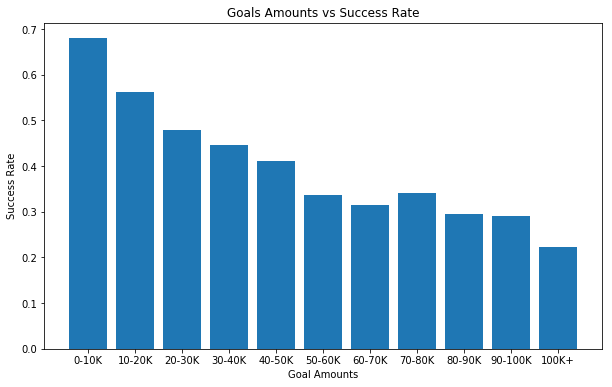

In [52]:
# Create plot
ind = [x for x, _ in enumerate(goal_list)]
plt.figure(figsize=(10, 6))
plt.bar(ind, goal_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Goals Amounts vs Success Rate")
plt.xticks(ind, goal_list)
plt.xlabel("Goal Amounts")

plt.show()

In [53]:
# Get list of success_rates for each goal
goal_success_rate = get_success_rate(goal_success_count_list, goal_fail_count_list)

print("Success rate per goal:")
for i, key in enumerate(goal_success):
    print(key, "{0:.2%}".format(goal_success_rate[i]))

print("\nMedian Goal: " + str(df['goal'].median()))
print("Mean Goal: " + str(df['goal'].mean()))
print("STD Goal: " + str(df['goal'].std()))

Success rate per goal:
0-10K 68.01%
10-20K 56.28%
20-30K 47.83%
30-40K 44.53%
40-50K 41.11%
50-60K 33.77%
60-70K 31.45%
70-80K 34.10%
80-90K 29.44%
90-100K 29.15%
100K+ 22.18%

Median Goal: 5000.0
Mean Goal: 22148.770978167908
STD Goal: 106275.08453662651


We see that the median goal was 5k while the mean goal was 22k. The data had a standard deviation of around $106,275. This difference in mean and median is significant and indicates a positive skew. There are less kickstarters that are aimed for large goals but these goals are significantly larger in amount than average.

The above data also shows the kickstarter success rate based on fundraiser goal in intervals of 10k USD. Kickstarters with a goal of 0-10k were clearly the most successful while kickstarters with a goal 100k+ were the least successful.  Looking at the data, there is a clear trend that kickstarters that aimed to raise less money were more successful than kickstarters that aimed to raise more money. This can be explained through the intuition that it is harder to raise more money.

Because a large majority of kickstarter projects were in the 0-10k region, we also broke down the 0-10k goal amounts into 10 buckets to see if there was anything significant.

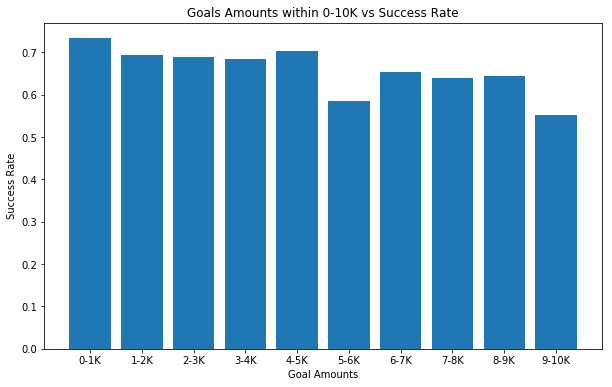

In [35]:
# Create plot
plt.figure(figsize=(10, 6))
plt.bar(ind, goal_subset_success_rate, width=0.8, label='Success Rate')

# Add labels, title, and legend
plt.ylabel("Success Rate")
plt.title("Goals Amounts within 0-10K vs Success Rate")
plt.xticks(ind, goal_subset_list)
plt.xlabel("Goal Amounts")

plt.show()

The trend is not as strong here as opposed to when looking at all kickstarter projects, but there is also a slight indication that kickstarters that aimed to raise less money were more successful than kickstarters that aimed to raise more money. Over the entirety of kickstarter projects, it is safe to say that lower goal projects are more likely to success due to the intuition stated previously.

### Privacy and Ethics Considerations

For our research question, we chose to look at what makes a kickstarter project successful.  This data was collected on a website whose owners got the data by webscrapping kickstarter.  The only potential privacy issue would be that the users of kickstarter did not give us direct consent to analyze their data.  However, because kickstarter is a public forum, in order to use the site, users do have to acknowledge that the data will note be private. 

Additionally, we aren’t using the data to create revenue and instead using it for an academic purpose. Thus, it’s unlikely there will be issues related to privacy. Furthermore, our data does not violate the safe harbor laws as no names, addresses or other identifying information is included within the dataset.


### Conclusion

We looked at many features of a kickstarter project and attempted to determine which ones had the greatest effect on the success of a kickstarter. These included: categories and subcategories, project description words, start date and duration, and goal amount. Our hypothesis was that the category of a kickstarter would have the greatest impact on the success, since some categories will inherently be more popular than others. We also hypothesized that Technology would be the most popular, due to the growing popularity surrounding technology-driven products.

Our results showed us that categories, in fact, did have the greatest impact

Categories: 30-80%
Words: 0%
Start Date: 50-60%
Duration: 0%
Goal Amount: 20-70%


### Discussion

We looked at each feature independently.

The following is a sample from TA:
There are possibly still many more factors that could determine the successfulness of a movie, but we are unable to cover them all. A few limitations of our project are: first, the dataset only contains 5000 movies. After excluding those entries with missing data(like missing budget and revenue), the dataset becomes even smaller. As a result, we don't have enough instances of movies of each genre for our analysis. Second, the dataset doesn't have the newest movies, making it not an ideal representitive of the most up-to-date situation. Thus, we are not sure if this dataset can well epitomize the recent movie industry's situations. Third, the dataset lacks more detailed information about movie budgets, such as the renumerations for movie actors and the spending on special effects, etc. Such infomation is curtial to our further analysis of the relationship between certain factors and the success of the movies. From there, we could make a more specific analysis. In a nut shell, although the dataset has much more information we could explore, it is still far from enough to find a guaranteed successful formula for movie makers.

In [94]:
ind = [x for x in range(1,13)]
spearmanr_coefficient, p_value = spearmanr(month_success_rate, ind)
print("Spearman's Rank Correlation Coefficient "+ "{:.3f}".format(spearmanr_coefficient))
print("p-val: ",p_value)

Spearman Rank Correlation Coefficient -0.469
p-val:  0.124454791188834


In [95]:
ind = [x for x in range(10)]
spearmanr_coefficient, p_value = spearmanr(duration_success_rate, ind)
print("Spearman's Rank Correlation Coefficient "+ "{:.3f}".format(spearmanr_coefficient))
print("p-val: ",p_value)

Spearman Rank Correlation Coefficient 0.394
p-val:  0.25999776683488757


In [102]:
ind = [x for x in range(11)]
spearmanr_coefficient, p_value = spearmanr(goal_success_rate, ind)
print("Spearman's Rank Correlation Coefficient "+ "{:.3f}".format(spearmanr_coefficient))
print("p-val: ",p_value)

Spearman Rank Correlation Coefficient -0.973
p-val:  5.14217704904919e-07
